In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.covariance import MinCovDet
from matplotlib.animation import FuncAnimation
import seaborn as sns

In [2]:
data_X, data_y = make_blobs(n_samples=3000, centers=6, cluster_std=1, random_state=42)

In [3]:
data_X

array([[ -3.40761229,   9.5062053 ],
       [ -7.79581911,  -7.7119318 ],
       [ -9.6109872 ,   8.15371473],
       ...,
       [  4.69652876,   2.50286244],
       [-10.36418494,   9.47716109],
       [  2.53718383,   4.98137681]])

In [4]:
data_y

array([0, 2, 3, ..., 1, 5, 4])

In [5]:
np.unique(data_y, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([500, 500, 500, 500, 500, 500]))

In [6]:
scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)

In [7]:
data_X

array([[ 0.02299832,  0.94280583],
       [-0.77464837, -2.09615435],
       [-1.10459244,  0.70409447],
       ...,
       [ 1.49609235, -0.2932675 ],
       [-1.24150159,  0.9376796 ],
       [ 1.10358707,  0.14418438]])

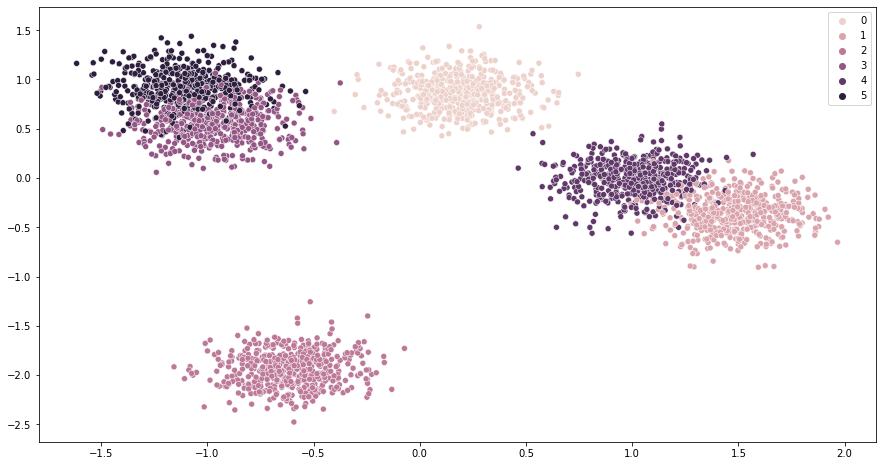

In [8]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=data_X[:,0], y=data_X[:,1], hue=data_y)
plt.show()

In [9]:
input_data_index = np.where((data_y==1) | (data_y==3) | (data_y==4) | (data_y==5))
anomaly_data_index = np.where(data_y==2)

In [10]:
input_data = (data_X[input_data_index])
input_data_label = (data_y[input_data_index])

In [11]:
anomaly_data = (data_X[anomaly_data_index])
anomaly_data_label = (data_y[anomaly_data_index])

In [12]:
input_data

array([[-1.10459244,  0.70409447],
       [ 1.3039643 , -0.50637738],
       [ 1.85176953, -0.36265885],
       ...,
       [ 1.49609235, -0.2932675 ],
       [-1.24150159,  0.9376796 ],
       [ 1.10358707,  0.14418438]])

In [13]:
train_X, test_X, train_y, test_y = train_test_split(input_data, input_data_label, test_size=0.75)

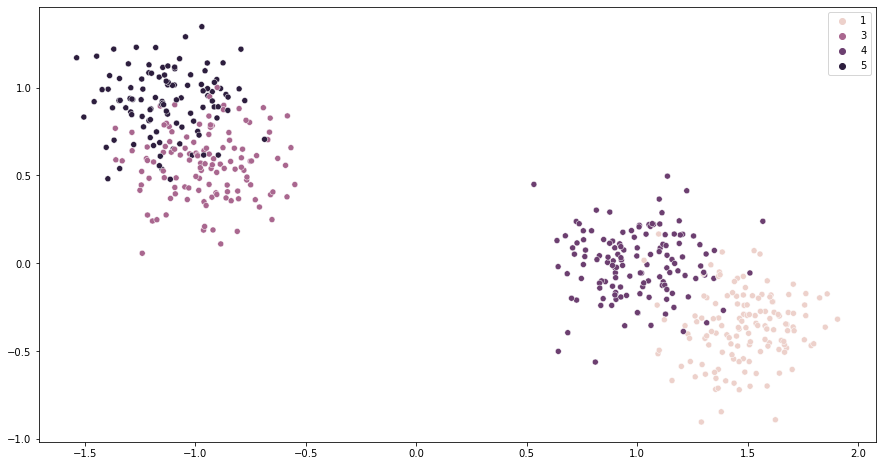

In [14]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=train_X[:,0], y=train_X[:,1], hue=train_y)
plt.show()

In [15]:
kmeans = KMeans(init='random', n_clusters=3, n_init=10, max_iter=10, random_state=42)

In [16]:
train_X_cluster_labels = kmeans.fit_predict(train_X)

In [17]:
train_X_cluster_centers = kmeans.cluster_centers_

In [18]:
unique_labels = np.unique(train_X_cluster_labels, return_counts=True)

In [19]:
sample_dict = {}
for i in unique_labels[0]:
    temp_array = np.zeros([unique_labels[1][i], train_X.shape[1]])
    count = 0
    for j in range(train_X_cluster_labels.shape[0]):
        if train_X_cluster_labels[j] == i:
            temp_array[count] = train_X[j]
            count = count + 1
    sample_dict[i] = temp_array

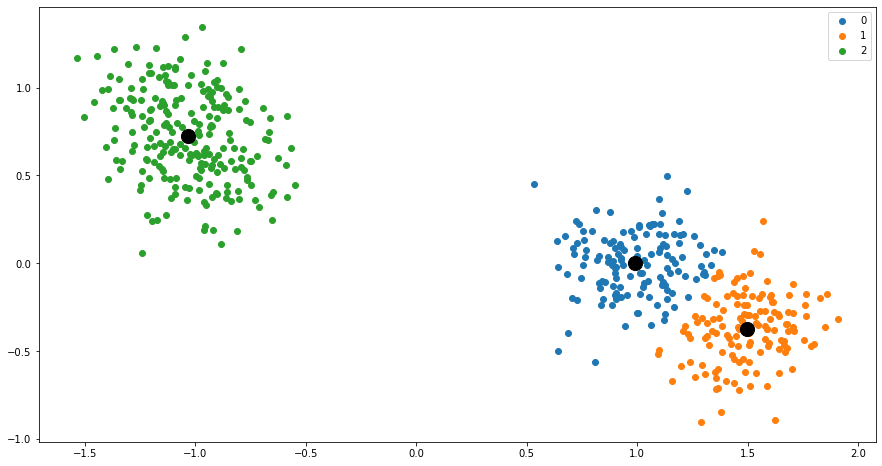

In [20]:
plt.figure(figsize=(15,8))
for i in list(sample_dict.keys()):
    plt.scatter(sample_dict[i][:,0], sample_dict[i][:,1], label=list(sample_dict.keys())[i])
plt.scatter(train_X_cluster_centers[:,0], train_X_cluster_centers[:,1], s=200, c='k')
plt.legend()
plt.show()

In [21]:
sample_dict[0].shape

(133, 2)

In [22]:
covariance_dict = {}
mean_dict = {}
last_update = {}
covariance_update_sum = {}
initial_sample_size = 0

for i in list(sample_dict.keys()):
    mcd = MinCovDet(random_state=42).fit(sample_dict[i])
    covariance_dict[i] = mcd.covariance_
    mean_dict[i] = mcd.location_
    initial_sample_size += sample_dict[i].shape[0]
    last_update[i] = 0
    covariance_update_sum[i] = np.zeros([sample_dict[i].shape[1], sample_dict[i].shape[1]])
    for j in range(sample_dict[i].shape[0]):
        covariance_update_sum[i] += (sample_dict[i][j][np.newaxis].T * sample_dict[i][j])
    

In [23]:
test_data = np.concatenate([test_X, anomaly_data[0:30]])

In [24]:
np.random.shuffle(test_data)

In [25]:
concept_drift_window = 100
anomaly_data_threshold = 6
test_predicted_label = np.zeros([test_data.shape[0],1])
test_mahal_dist = np.zeros([test_data.shape[0],1])
clusters_mean = np.zeros([test_data.shape[0], len(list(mean_dict.keys())), np.shape(list(mean_dict.values()))[1]])
total_samples = 0

for dynamic_sample_index in range(test_data.shape[0]):
    
    #take new dynamic input
    x = test_data[dynamic_sample_index]
    
    #calculate total no. of samples considering the initial size
    total_samples = initial_sample_size + dynamic_sample_index
    
    #calculate the mahalanobis distance of input with each estimator
    mahal_dist = {}
    for i in list(mean_dict.keys()):
        x_mu = x - mean_dict[i]
        inv_cov = np.linalg.inv(covariance_dict[i])
        left = np.dot(x_mu, inv_cov)
        mahal_dist_square = np.dot(left, x_mu[np.newaxis].T)
        mahal_dist[i] = np.sqrt(mahal_dist_square)

    #find the index of the cluster having the minimum mahalanobis distance along with the mahalanobis distance itself
    min_cluster_index = list(mahal_dist.items())[0][0]
    min_mahal_dist = list(mahal_dist.items())[0][1]
    for (cluster_index, cluster_mahal_dist) in mahal_dist.items():        
        if (cluster_mahal_dist - min_mahal_dist) < 0:
            min_cluster_index = cluster_index
            min_mahal_dist = cluster_mahal_dist
    
    #associate the positive label to new input or anomaly label (0) in case of anomaly
    if (min_mahal_dist - anomaly_data_threshold) < 0:
        test_predicted_label[dynamic_sample_index] = 1
    else:
        test_predicted_label[dynamic_sample_index] = 0
    
    #calculated weighted input
    weighted_x = (min_mahal_dist*mean_dict[min_cluster_index] + x)/(min_mahal_dist + 1)
    
    #update the mean of cluster having the minimum mahalanobis distance for the new input
    mean_dict[min_cluster_index] = ((total_samples * mean_dict[min_cluster_index]) +  weighted_x)/(total_samples + 1)
    for i in list(mean_dict.keys()):
        clusters_mean[dynamic_sample_index][i] = mean_dict[i]
    
    #update the covariance of cluster having the minimum mahalanobis distance for the new input
    weight_x_mat = (weighted_x[np.newaxis].T * weighted_x)
    mean_mat = (mean_dict[min_cluster_index][np.newaxis].T * mean_dict[min_cluster_index][np.newaxis])
    covariance_dict[min_cluster_index] = (covariance_update_sum[min_cluster_index] + weight_x_mat - mean_mat)/(total_samples + 1)
    
    #update the covraiance summation update value to be used for the next input
    covariance_update_sum[min_cluster_index] += (x[np.newaxis].T * x)
    
    #update the last_update index of the cluster having the minimum mahalanobis distance for the new input
    last_update[min_cluster_index] = dynamic_sample_index + 1
    
    #finding the minimum value of last update from all the clusters
    min_last_update = list(last_update.items())[0][1]
    for (cluster_last_update_index, cluster_last_update) in last_update.items():
        if (cluster_last_update < min_last_update):
            min_last_update = cluster_last_update
    
    if (dynamic_sample_index - min_last_update) > concept_drift_window:
        print("Drift has occured")

In [26]:
unique_test_labels = np.unique(test_predicted_label, return_counts=True)

In [27]:
sample_test_dict = {}
for i in range(np.shape(unique_test_labels)[1]):
    temp_array = np.zeros([unique_test_labels[1][i], test_data.shape[1]])
    count = 0
    for j in range(test_predicted_label.shape[0]):
        if (test_predicted_label[j] == unique_test_labels[0][i]):
            temp_array[count] = test_data[j]
            count = count + 1
    sample_test_dict[unique_test_labels[0][i]] = temp_array

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


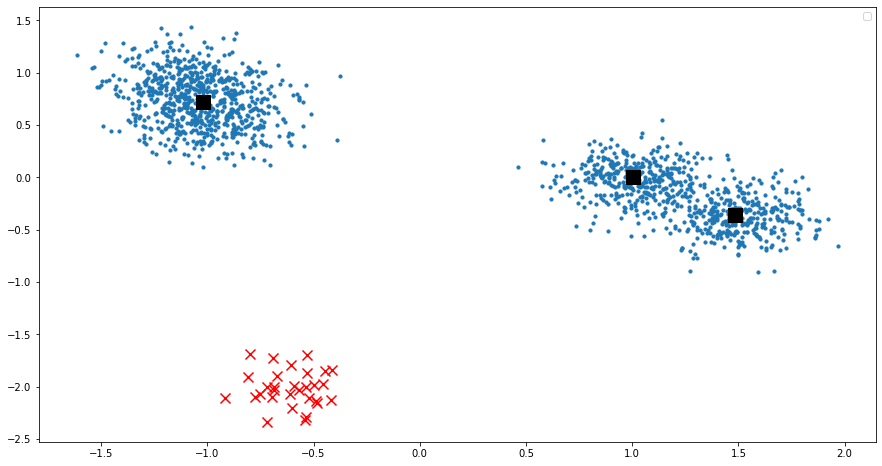

In [28]:
plt.figure(figsize=(15,8))
for i in list(sample_test_dict.keys()):
    if i == 0:
        plt.scatter(sample_test_dict[i][:,0], sample_test_dict[i][:,1], s=100, c='r', marker='x')
    else:
        plt.scatter(sample_test_dict[i][:,0], sample_test_dict[i][:,1], s=10, marker='o')

for i in list(mean_dict.keys()):
    plt.scatter(mean_dict[i][0], mean_dict[i][1], s=200, c='k', marker='s')
plt.legend()
plt.show()

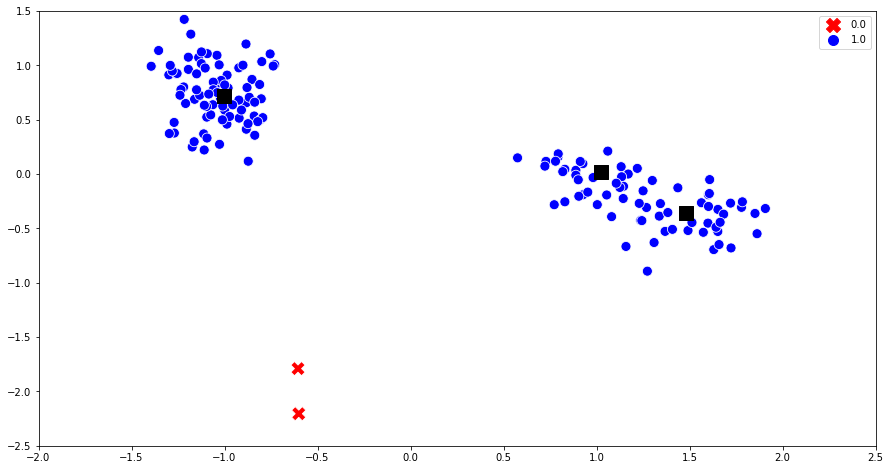

In [29]:
sample_window = int(test_data.shape[0]/10)
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
def animate(i):
    ax.clear()
    if (i<=sample_window):        
        sns.scatterplot(x=test_data[0:i,0], y = test_data[0:i,1], hue = test_predicted_label[0:i,0], style = test_predicted_label[0:i,0], markers={0:'X', 1:'o'}, palette={0:'red', 1:'blue'},
                        size=test_predicted_label[0:i,0], sizes=(100,200))
    else:
        sns.scatterplot(x=test_data[(i-sample_window):i,0], y=test_data[(i-sample_window):i,1], hue = test_predicted_label[(i-sample_window):i,0], style = test_predicted_label[(i-sample_window):i,0], markers={0:'X', 1:'o'},
                        palette={0:'red', 1:'blue'}, size=test_predicted_label[(i-sample_window):i,0], sizes=(100,200))
    ax.set_xlim([-2,2.5])
    ax.set_ylim([-2.5,1.5])
    for j in range(clusters_mean.shape[1]):
        plt.scatter(clusters_mean[i][j][0], clusters_mean[i][j][1], s=200, c='k', marker='s')

ani = FuncAnimation(fig, animate, frames=test_data.shape[0], interval=50, repeat=False)

ani.save("MIR_MAD_KMEANS.mp4")
plt.show()